In [3]:
import nltk
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re #import the regular expression library
import string
import os
import json
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import load_files
from nltk import pos_tag
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords #import the stopwords from the ntlk.corpus library
nltk.download('stopwords')
from nltk.tokenize import word_tokenize #import the word_tokenize method, which is used to turn sentences into words"
nltk.download('punkt')
from collections import Counter
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('wordnet')
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
FullPaper=[]
directories = ["biorxiv_medrxiv"]
for directory in directories: #for each of the three folders carrying the json format of different research papers
    for file in tqdm(os.listdir(f"{directory}/{directory}/pdf_json")): #for every json file
        file_path=f"{directory}/{directory}/pdf_json/{file}" #set the file path to the file_path variable 
        paper = json.load(open(file_path,"rb"))
        title = paper['metadata']['title'] 
        try:
            abstract = paper['abstract']
        except:
            abstarct=""                
        full_text=""     
        
        for text in paper['body_text']:
            full_text +=text['text'] +'\n\n' 
        FullPaper.append([title,abstract,full_text])
        
FullPaperDataframe=pd.DataFrame(FullPaper,columns=['title','abstract','full_text'])

100%|██████████| 1934/1934 [01:02<00:00, 31.13it/s]


> Our aim is to address these points:
* Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.

In [6]:
full_text = FullPaperDataframe['full_text'].head(300)
clean_text = [] #a list which will hold all the bodies of the papers after being stripped out of stopwords
wnl = WordNetLemmatizer()
porter = PorterStemmer()
# punctuation_regex = string.punctuation
# punctuation_regex = punctuation_regex.replace("-", "") # keep the hyphens
# pattern = r"[{}]".format(punctuation_regex) # generate the regex pattern
pattern = """!"#$%&'()*+,.:;<=>?@[\]^`{|}~""" #the pattern which will account for punctuation, and will later be used to remove them
#cleaning the data and removing stop words
for val in  tqdm(full_text):
        body_tokens = word_tokenize(val)
        paper_body_without_stopwords = [token.lower() for token in body_tokens if not token.lower() in stopwords.words('english') and nltk.pos_tag([token.lower()])!='PRP'] #remove the stop words in the body and return a list
        clean_string = ' '.join(paper_body_without_stopwords).lower() #convert the list into string
        clean_string = re.sub(rf"[{pattern}]", '', clean_string)#remove punctuation except for hyphens
        clean_string = re.sub(r"\bthe\b", r"", clean_string) #remove the
        clean_string = re.sub(r'\bwe\b', '',clean_string ) #remove the pronoun we
        clean_string = re.sub(r'\bit\b', '',clean_string )#remove the pronoun it
        clean_string = re.sub(r'\bthey\b', '',clean_string )#remove the pronoun they
        clean_string = re.sub(r'\bcopyright\b', '',clean_string )#remove the word copyright
        clean_string = re.sub(r'\bhttps\b', '',clean_string )#remove the word https
        clean_string = re.sub(r'\bet\b', '',clean_string )#remove the word et
        clean_string = re.sub(r'\bal\b', '',clean_string )#remove the word al
        clean_string = re.sub(r'\bpreprint\b', '',clean_string )#remove the word preprint
        clean_string = re.sub(r'\bthis\b', '',clean_string )#remove the word this
        clean_string = re.sub(r'\bthese\b', '',clean_string )#remove the word these
        clean_string = re.sub(r'\balso\b', '',clean_string )#remove the word also
        clean_string = re.sub(r'\bhowever\b', '',clean_string )#remove the word however
        clean_string = re.sub(r'\balthough\b', '',clean_string )#remove the word although
        clean_string = re.sub(r'\bamong\b', '',clean_string )#remove the word among
        clean_string = re.sub(r'\bin\b', '',clean_string )#remove the preposition in
        clean_string = re.sub(r'\bmedrxiv\b', '',clean_string )#remove the word medrxiv
        clean_string = re.sub(r'\bbiorxiv\b', '',clean_string )#remove the word mbiorxiv
        clean_string = re.sub(r'\blicense\b', '',clean_string )#remove the word license
        clean_string = re.sub(r'\bwithout\b', '',clean_string )#remove the word without
        clean_string = re.sub(r'\bfig\b', '',clean_string )#remove the word fig
        clean_string = re.sub(r'\bfigure\b', '', clean_string)#remove the word figure
        clean_string = re.sub(r'\b[a-zA-Z]\b', '', clean_string)#remove all the single letters      

        clean_string = re.sub(r'^\d+\s|\s\d+\s|\s\d+$', '', clean_string) #remove any digit that is not part of a word
        clean_text.append(clean_string) #add the string to the list 
stemmed_text=[] # a list which will contain the stemmed bodies of all docs      
for val in clean_text: #for the body (which was stripped out of stop words) of each paper
    stemmed_val="" #create an empty string
    words = val.split(' ') #split body of paper on spaces
    for word in words: #for each word in the body
        if(word!=""): #if the word is not an empty string
            if (word=="coronaviruses"):#since the stem and lemmatize functions do not recognize the word coronaviruses as the plural of coronavirus, a conidition was created
                word ="coronavirus"
            stem_lemma =wnl.lemmatize(word) if wnl.lemmatize(word).endswith('e') else porter.stem(word)
            stemmed_val+=stem_lemma+" " #stem/lemmatize the word and concat it to the string stemmed_val
    stemmed_text.append(stemmed_val) #add the string stemmed_val to the list which will contain the stemmed bodies of all docs  

100%|██████████| 300/300 [23:29<00:00,  4.70s/it]  


In [7]:
# this cell is no longer needed and is kept for reference


text = ' '.join(stemmed_text) #convert all the stemmed bodies into one string containing all the stemmed bodies of all papers 
s=text.split(' ')#split the combination of papers body on space
vocab_count = Counter(s)# count the number of vocab (unique words)
most_occur = vocab_count.most_common(200) #get the most common 200 words
#print(most_occur) #print the most common 200 words

In [8]:
#create a tf-idf matrix for the words above
v = TfidfVectorizer(sublinear_tf = True, min_df = 0.05,max_df = 0.8)
#For the above vectorizer, the first paramater specifies that the 1+log(tf) is going to be used instead of tf.
#The second parameter specifies that if a term appears in less than 5% of the docs, ignore it
#The third parameter, considers word that do not occur in more than 80% of the corpus
tfidf = v.fit_transform(stemmed_text) #fit and transform the stemmed texts which were previously cleaned.
print(sorted(v.vocabulary_.items(), key=lambda x : x[1]))
print(tfidf.toarray())

[('03', 0), ('05', 1), ('10', 2), ('100', 3), ('11', 4), ('12', 5), ('13', 6), ('14', 7), ('15', 8), ('16', 9), ('17', 10), ('18', 11), ('19', 12), ('1a', 13), ('1b', 14), ('1c', 15), ('1d', 16), ('1e', 17), ('20', 18), ('2019', 19), ('2020', 20), ('202003', 21), ('21', 22), ('229e', 23), ('23', 24), ('24', 25), ('25', 26), ('26', 27), ('27', 28), ('28', 29), ('29', 30), ('2a', 31), ('2b', 32), ('2c', 33), ('2d', 34), ('30', 35), ('31', 36), ('34', 37), ('35', 38), ('37', 39), ('38', 40), ('3a', 41), ('3b', 42), ('3c', 43), ('3d', 44), ('3e', 45), ('40', 46), ('4a', 47), ('4b', 48), ('4c', 49), ('4d', 50), ('50', 51), ('56', 52), ('5a', 53), ('5b', 54), ('5c', 55), ('5d', 56), ('60', 57), ('6a', 58), ('6b', 59), ('6c', 60), ('70', 61), ('80', 62), ('95', 63), ('96', 64), ('abil', 65), ('able', 66), ('abnorm', 67), ('above', 68), ('absence', 69), ('absolute', 70), ('abund', 71), ('abundance', 72), ('acceler', 73), ('accept', 74), ('access', 75), ('accessible', 76), ('accompani', 77), ('

In [ ]:
# #Next, the search engine will be implemented with the help of the tf-idf matrix created above and the cosine similarity
# query = input("Enter your query: ") 
# finalQuery="" #create an empty string
# words = query[0].split(' ') #split the query on spaces
# print (words)
# for word in words: #for each word in the query
#     if(word!=""): #if the word is not an empty string
#         if (word=="coronaviruses"):#since the stem and lemmatize functions do not recognize the word coronaviruses as the plural of coronavirus, a conidition was created
#             word ="coronavirus"
#         stem_lem_query =wnl.lemmatize(word) if wnl.lemmatize(word).endswith('e') else porter.stem(word)
#         finalQuery+=stem_lem_query+" " #stem/lemmatize the word and concat it to the string stemmed_val
# query = [finalQuery]
# print (query)
# query_tfidf = v.transform(query)
# cosineSimilarities = cosine_similarity(query_tfidf, tfidf).flatten()
# print(cosineSimilarities)

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.90) #keep 90% of the variance
tf_idf_norm_kmeans= pca.fit_transform(tfidf.toarray())

100%|██████████| 19/19 [00:05<00:00,  3.73it/s]


<Figure size 1440x1440 with 0 Axes>

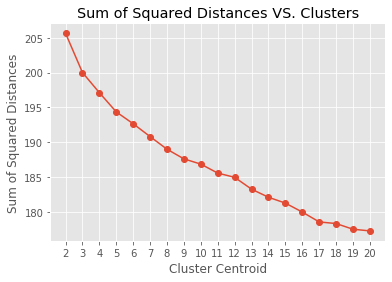

<Figure size 1440x1440 with 0 Axes>

In [17]:
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
plt.style.use('ggplot')
max_number_of_clusters = 20
max_number_of_clusters = max_number_of_clusters+1 # since the range method is exclusive, a one should be added.
Ks = range(2, max_number_of_clusters, 1) #Hold the range of clusters k (from 2-max_number_of_clusters)
    
sum_of_squared_distances = [] #a list which will carry the sum of squared distances at each k
for k in tqdm(Ks):
    sum_of_squared_distances.append(KMeans(n_clusters=k).fit(tf_idf_norm_kmeans).inertia_)#calculate the sum of squared distance.
        
        
f, ax = plt.subplots(1, 1)
ax.plot(Ks, sum_of_squared_distances, marker='o')
ax.set_xlabel('Cluster Centroid')
ax.set_xticks(Ks)
ax.set_xticklabels(Ks)
ax.set_ylabel('Sum of Squared Distances')
ax.set_title('Sum of Squared Distances VS. Clusters')
plt.figure(figsize=(20,20))

In [18]:
clusters = KMeans(n_clusters=12).fit_predict(tf_idf_norm_kmeans)

df =FullPaperDataframe.head(300)
df['clusters'] = clusters
df.head()
clusters

c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


array([ 3,  8,  6,  4,  3,  0,  9,  2, 11,  1,  2,  6,  2, 11,  3,  6,  1,
        2,  6,  3,  1,  1,  6,  9,  4,  1,  6,  4,  6,  0,  1,  2,  6,  0,
        3,  3,  1,  8,  2,  7,  2,  3,  1,  6,  8,  6, 11,  3,  2,  2,  1,
        1,  1,  1, 11,  2,  7, 10,  3,  1,  6,  7,  0,  1,  1,  6,  0,  3,
        7,  6,  6,  3,  2, 10,  6,  2,  2, 10,  0,  1,  6,  7,  3,  3,  4,
        1,  6,  2,  4,  0,  6,  8,  0,  0,  6,  3,  6,  1,  9,  6,  2,  0,
        2,  7,  6,  6, 11,  6,  7,  8,  8,  2,  3,  7,  1,  2,  9,  1,  0,
        2,  0,  3,  1,  9,  5,  2,  6,  6,  6, 10,  1,  8,  9,  1,  2,  4,
        6,  8, 11,  1, 10,  4,  6,  7,  5,  2, 11,  6,  2,  8,  0,  4, 11,
        8,  7,  5,  6,  4,  6, 11,  0,  0,  6,  5,  3,  7,  7,  5,  0,  3,
        8,  0,  6,  3, 10,  7,  9,  6,  3,  6,  3,  0,  8,  3,  0,  9,  0,
       10, 11,  0,  0,  5,  0, 10,  9,  0, 11,  1,  0,  4,  7,  6,  3,  8,
        2,  7, 11,  2,  6,  0,  6,  6,  1,  7,  2,  1,  0,  6, 11,  0,  1,
        2, 10,  6,  8,  7

In [ ]:
#tf- idf
# # finding the tf-idf matrix for all the abstracts
# # vec = TfidfVectorizer()

# # ve = vec.fit_transform(clean_abs)

# # # displaying the tf-idf of the word in the abstact  
# # pd.DataFrame(ve.toarray(), columns=sorted(vec.vocabulary_.keys()))

# # #applying tf-idf cosine similarity and printing the result(testing)
# # query = ["prophylaxis"]
# # query_tfidf = vec.transform(query)
# # cosineSimilarities = cosine_similarity(query_tfidf, ve).flatten()
# # print(cosineSimilarities)

In [ ]:
# taged_abs=[]
# nouns=[]
# # tagging the clean data
# for val in clean_abs:
#     taged_abs.append(pos_tag(val.split()))
# # extracting the nouns
# for i in range(len(taged_abs)):
#     doc=[]
#     for j in range(len(taged_abs[i])):
#         if(taged_abs[i][j][1]=='NN' or taged_abs[i][j][1]=='NNS'):
#             doc.append(taged_abs[i][j][0])
#     nouns.append(doc)
        
# print(nouns)



Above we dcided to calculate the tf-idf so that we can represent every word that is present in the abstract quatitavily. By doing so we can further use the results in order model the topic according to the abstract that we just quatified.Furthermore we will use (Non-negative Matrix Factorization) NMF in order to come up with topic's that carry most weight in the abstract. To accomplish this we are going to filter all the nouns that are avaliable in the abstract and use them to represent the different topis that are avaliable.